# Исследование объявлений о продаже квартир

У нас есть данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Мы будем определять рыночную стоимость объектов недвижимости.

**Цель исследования** — установить особенности недвижимости в Санкт-Петербурге и окрестностях. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

**План исследования**:

1. Предобработка данных
* Обработка пропусков
* Обработка дубликатов
* Определение аномальных значений
2. Исследовательский анализ данных
* Добавление новые столбцов в таблицу
* Построение гистограмм по основным параметрам
* Выявление факторов, которые влияют на цену

### Знакомство с данными

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [158]:
try:
    df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

except:
    df = pd.read_csv('~/Practicum/real_estate_data.csv', sep='\t')

In [159]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

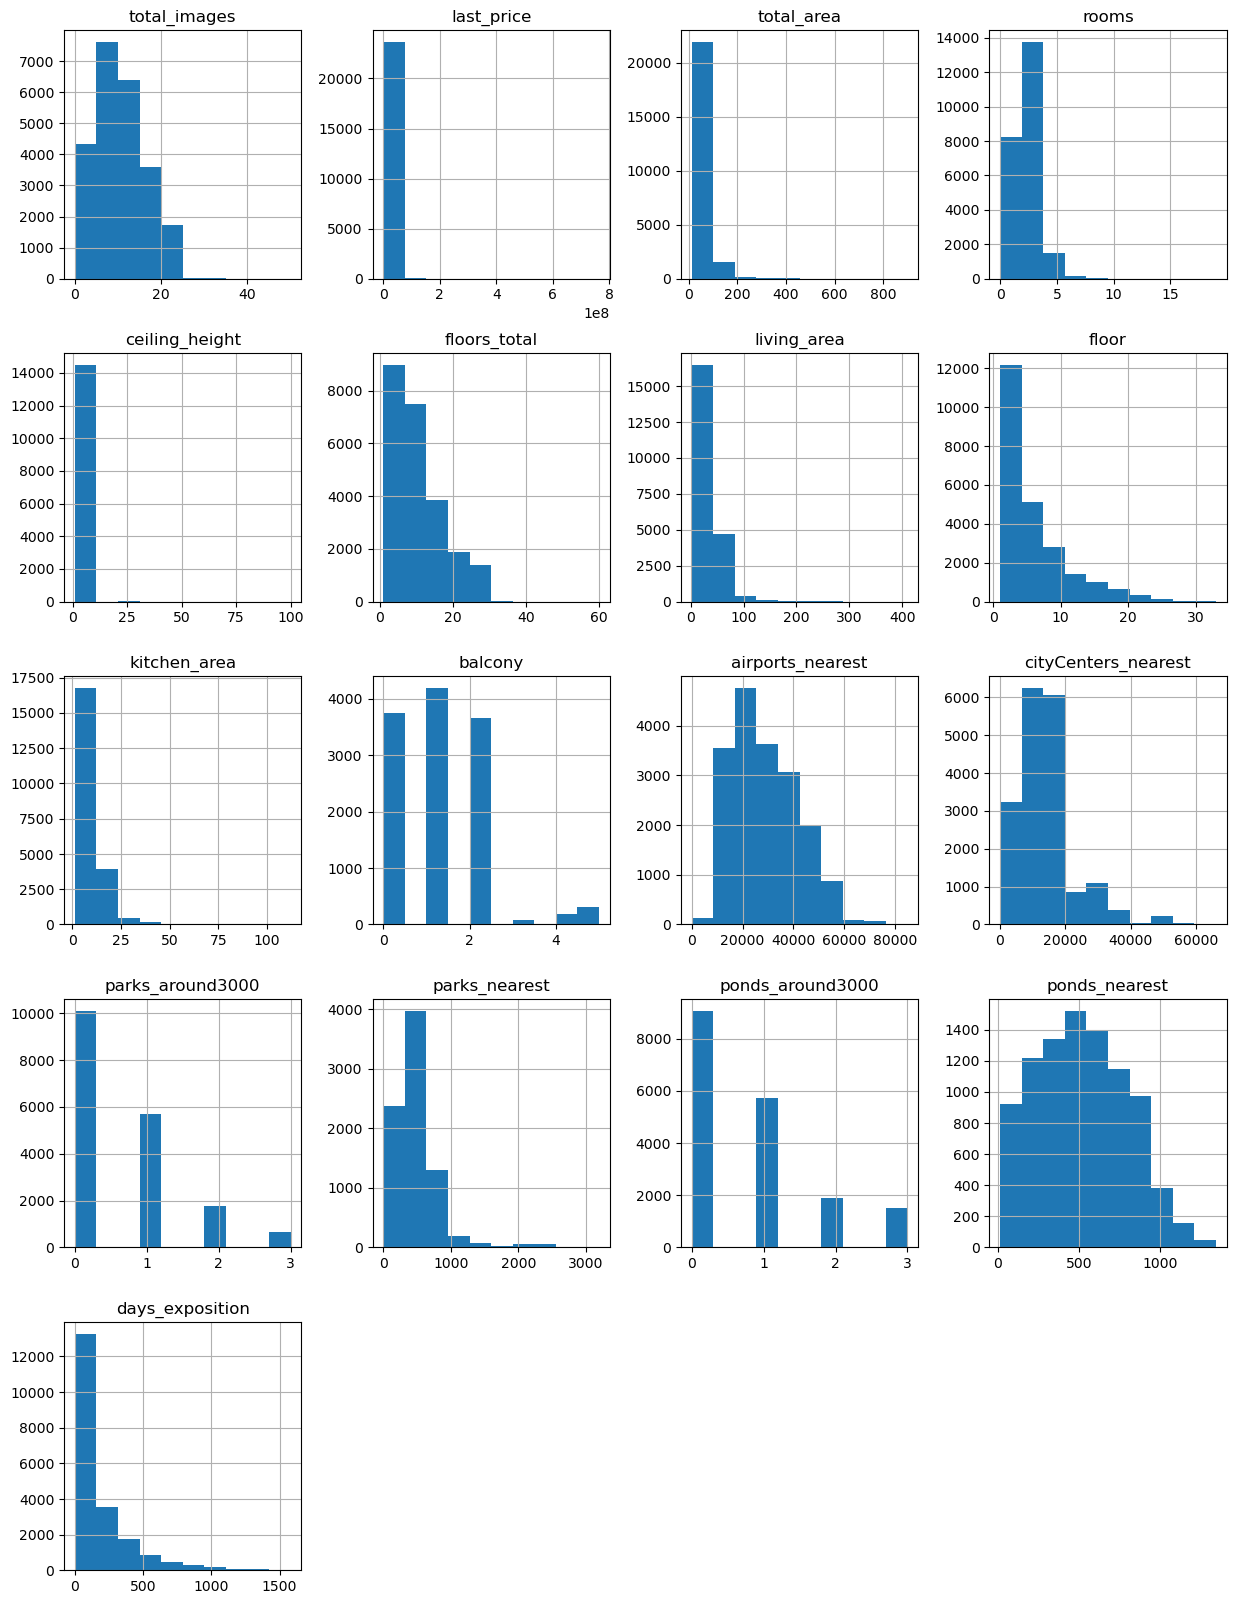

In [161]:
df.hist(figsize=(15, 20));

### Предобработка данных

#### Пропуски значений

Посмотрим на количество пропусков в столбцах:

In [162]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), legend = False, fontsize = 16)
            .set_title('Количество пропусков в столбцах' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

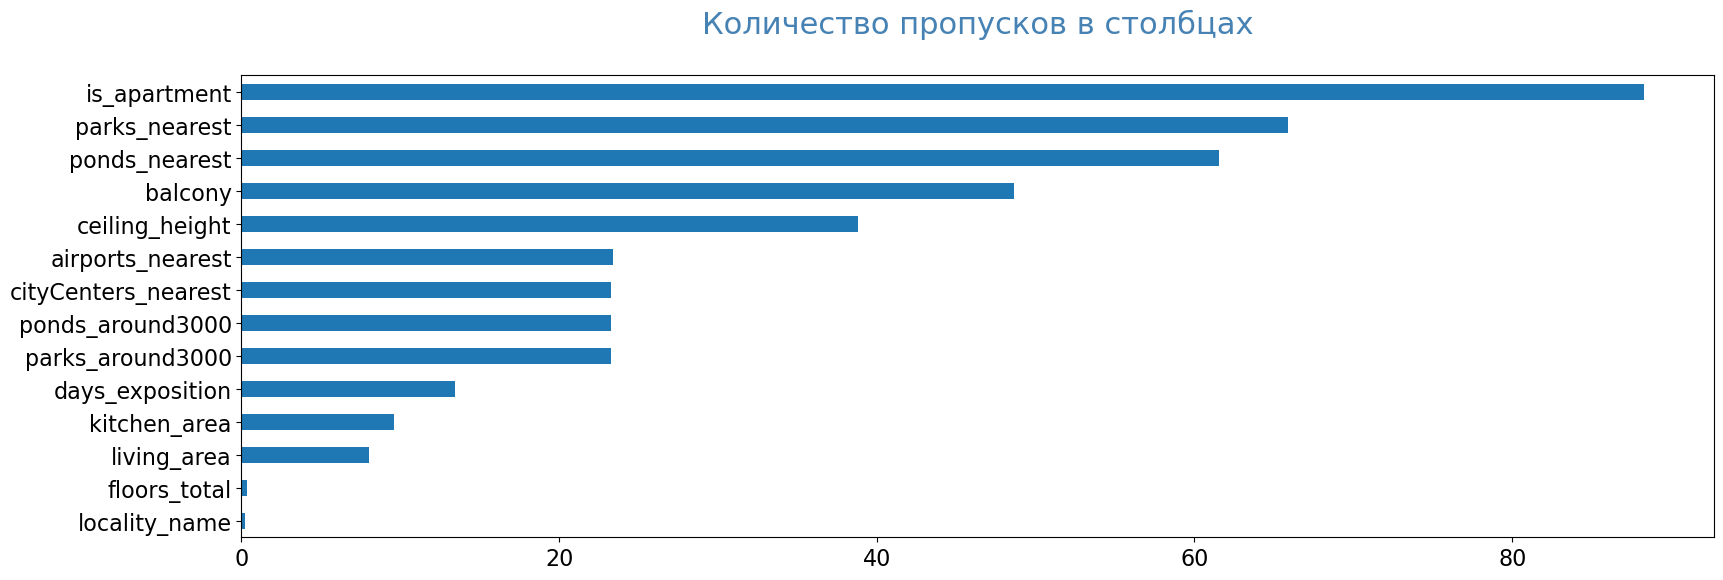

In [163]:
pass_value_barh(df)

Исходя из логики таблицы, мы можем предположить, что часть пропусков носит чисто технический характер: произошла ошибка при записи булевой переменной. Например, так произошло в случае столбцов "наличие  балкона" и "апартамент". Если суммировать имеющиеся пропуски со значениями, которые уже в таблице, то получается общая сумма значений. В этих случаях мы заменим NaN на True.

In [164]:
df['is_apartment'] = df['is_apartment'].fillna(True)

In [165]:
df['balcony'] = df['balcony'].fillna(True)

Проверим результаты устранения пропусков.

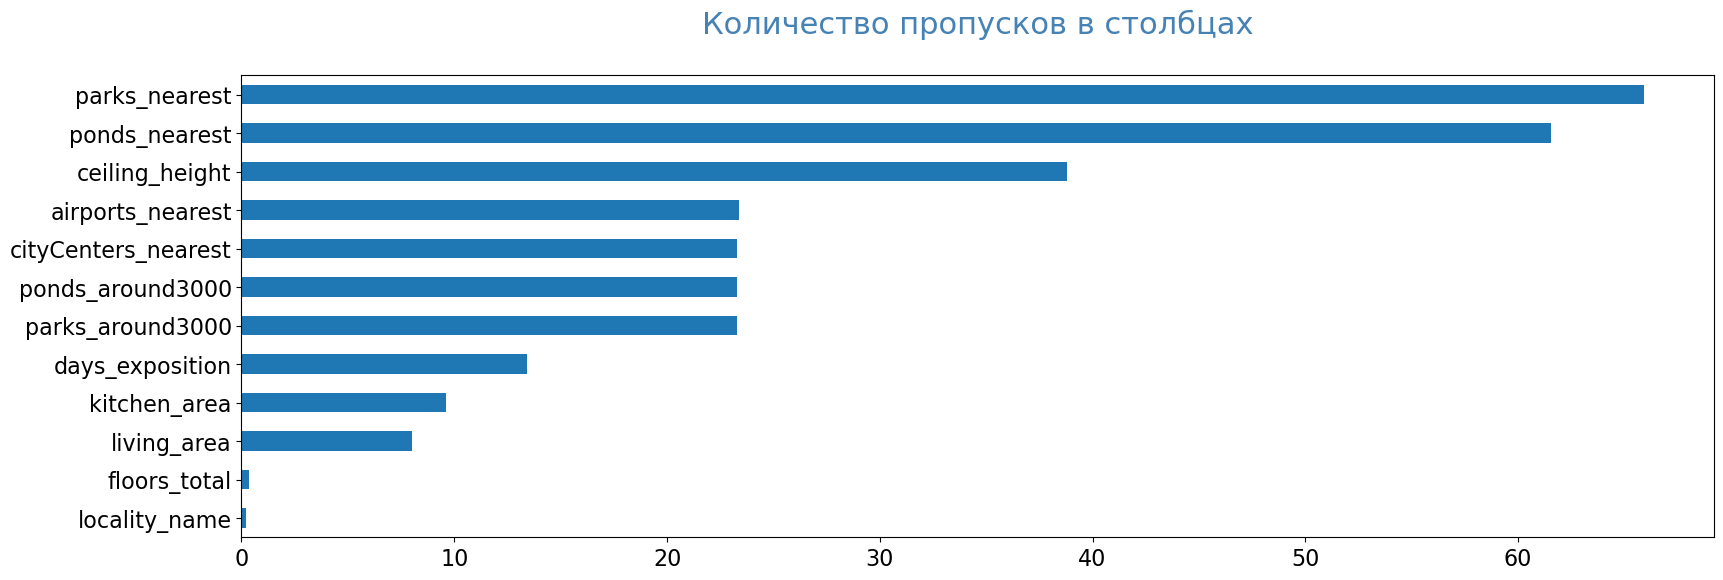

In [166]:
pass_value_barh(df)

Итак, мы провели замену там, где это возможно. В таблице осталось много других пропусков, которые можно объяснить двумя причинами: информация не была введена человеком (например, kitchen_area), либо произошла ошибка при обработке данных (например, столбцы с airports_nearest по ponds_nearest). Все эти столбцы объединяет то, что они содержат картографические данные.

#### Переименование столбцов

Заменим CamelCase на snake_case.

In [167]:
df = df.rename(columns={"cityCenters_nearest" : 'nearest_city_center'})

#### Типы данных

Анализ общей информации о таблице показал, что многие столбцы имеют неверный тип данных. Большое количество столбцов с float64, где значения после запятой не используются. Тип float64 установлен для столбца balcony, где логичнее всего поставить bool. Наконец, столбец first_day_exposition обозначен как object, тогда как содержит дату и время, для чего в Питоне есть особый тип данных - datetime.

Исправим указанные недостатки. Начнем с целых чисел.

In [168]:
df['last_price'] = df['last_price'].astype(int)

In [169]:
df['floors_total'] = df['floors_total'].astype('Int64', errors='ignore')

In [170]:
df['airports_nearest'] = df['airports_nearest'].astype('Int64', errors='ignore')

In [171]:
df['nearest_city_center'] = df['nearest_city_center'].astype('int', errors='ignore')

In [172]:
df['parks_around3000'] = df['parks_around3000'].astype('Int64', errors='ignore')

In [173]:
df['parks_nearest'] = df['parks_nearest'].astype('Int64', errors='ignore')

In [174]:
df['ponds_around3000'] = df['ponds_around3000'].astype('Int64', errors='ignore')

In [175]:
df['ponds_nearest'] = df['ponds_nearest'].astype('Int64', errors='ignore')

In [176]:
df['days_exposition'] = np.floor(pd.to_numeric(df['days_exposition'], errors='coerce')).astype('Int64')

Теперь обратимся к типам boolean и datetime.

In [177]:
df['balcony'] = df['balcony'].astype(bool)

In [178]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Проверим результаты исправлений.

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int32         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  Int64         
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

#### Уникальные значения

Выясним, нет ли повторов в столбце locality_name. Он состоит из текстовых данных, которые часто содержат в себе опечатки или другие ошибки ввода.

In [180]:
df['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

Узнаем количество уникальных названий в столбце.

In [181]:
df['locality_name'].sort_values().nunique()

364

В таблице присутствуют неявные дубликаты, т.е. объекты, записанные по-разному. Создадим новый столбец, куда добавим только важные опознавательные признаки каждой локации (имя собственное), а типы населенных пунктов отбросим. Фильтр грубый, но позволяет отловить наиболее частые повторы.

In [182]:
df['locality_name_new'] = df['locality_name'].str.replace('поселок', '')
df['locality_name_new'] = df['locality_name_new'].str.replace('посёлок', '')
df['locality_name_new'] = df['locality_name_new'].str.replace('станции', '')
df['locality_name_new'] = df['locality_name_new'].str.replace('при железнодорожной станции', '')
df['locality_name_new'] = df['locality_name_new'].str.replace('городской', '')
df['locality_name_new'] = df['locality_name_new'].str.replace('городского типа', '')
df['locality_name_new'] = df['locality_name_new'].str.replace('деревня', '')
df['locality_name_new'] = df['locality_name_new'].str.replace('садовое товарищество', '')
df['locality_name_new'] = df['locality_name_new'].str.replace('село', '')
df['locality_name_new'] = df['locality_name_new'].str.replace('коттеджный', '')
df['locality_name_new'] = df['locality_name_new'].str.strip()

Посмотрим на результаты работы.

In [183]:
df['locality_name_new'].sort_values().nunique()

307

#### Аномальные значения

##### Высота потолков

Проанализируем столбец высота (ceiling_height) на предмет наличия аномалий.

In [184]:
df['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

<AxesSubplot:>

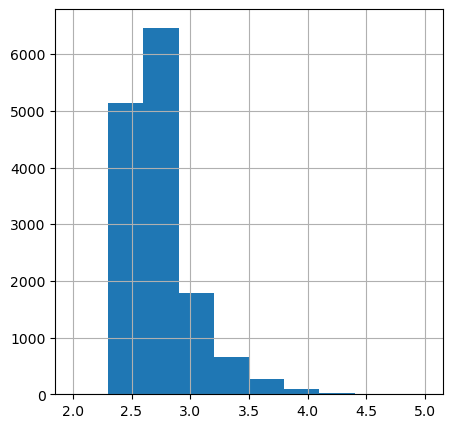

In [185]:
df['ceiling_height'].hist(grid=True, range=(2,5), figsize=(5, 5))

[(2.0, 4.0), Text(0.5, 1.0, 'Высота потолков (м)')]

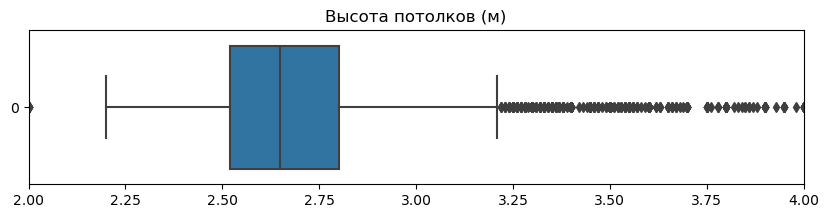

In [186]:
plt.figure(figsize=(10, 2))
ax = sns.boxplot(data=df['ceiling_height'], orient="h")
ax.set(
    xlim = [2, 4],
    title = 'Высота потолков (м)'
)

Как мы видим, диапазон значений (1-100) выглядит не очень реалистично. Возможно, возникли ошибки при записи данных: 2.7м превратились в 27м. Исправим данные, поделив значения на 10. Для нашего исследования мы оставим только значения комнат до 7, т.к. остальные требуют особого подхода.

In [187]:
df.loc[(df['ceiling_height'] > 22) & (df['ceiling_height'] <= 32), 'ceiling_height'] = df['ceiling_height'] / 10

Теперь ограничим высоту потолков снизу и сверху: от 2м до 3.5м.

У нас остались пропуски в значениях, которые мы хотим сохранить, чтобы не исказить данные, поэтому добавим к фильтру условие сохранять пропуски.

In [188]:
df = df.query('ceiling_height > 2 or ceiling_height.isnull()', engine='python')

In [189]:
df = df.query('ceiling_height < 3.5 or ceiling_height.isnull()', engine='python')

Проверим результаты работы.

In [190]:
df['ceiling_height'].describe()

count    14077.000000
mean         2.697601
std          0.210527
min          2.200000
25%          2.500000
50%          2.650000
75%          2.800000
max          3.490000
Name: ceiling_height, dtype: float64

[(2.0, 3.75), Text(0.5, 1.0, 'Высота потолков (м)')]

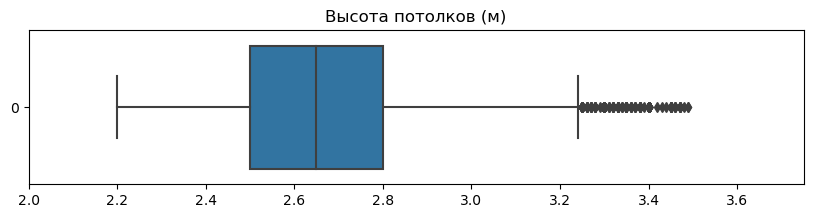

In [191]:
plt.figure(figsize=(10, 2))
ax = sns.boxplot(data=df['ceiling_height'], orient="h")
ax.set(
    xlim = [2, 3.75],
    title = 'Высота потолков (м)'
)

Мы видим, что осталось небольшое количество выбросов, которые мы не можем удалить без серьёзного изменения в выборке. Общая картина уже сейчас выглядит более строго.

##### Жилплощадь

Похожим образом мы можем разобраться со значениями столбца жилплощадь (living_area).

In [192]:
df['living_area'].describe()

count    21398.000000
mean        33.715881
std         20.160956
min          2.000000
25%         18.500000
50%         30.000000
75%         42.000000
max        409.700000
Name: living_area, dtype: float64

[Text(0.5, 1.0, 'Жилая площадь (м²)')]

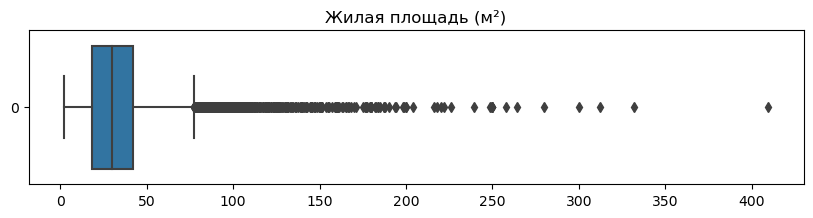

In [193]:
plt.figure(figsize=(10, 2))
ax = sns.boxplot(data=df['living_area'], orient="h")
ax.set(
    title = 'Жилая площадь (м²)'
)

<AxesSubplot:>

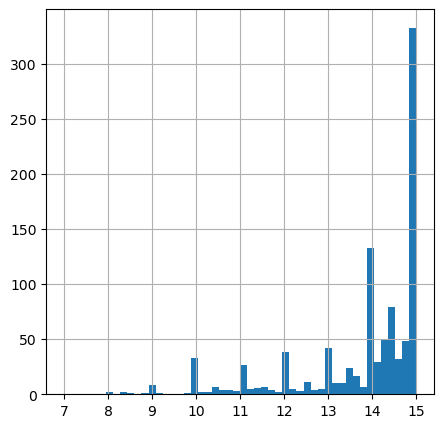

In [194]:
df['living_area'].hist(grid=True, range=(7, 15), bins=50, figsize=(5, 5))

In [195]:
df = df.query('(living_area > 9 and living_area < 100) or living_area.isnull()', engine='python')

In [196]:
df['living_area'].describe()

count    21101.000000
mean        32.369979
std         15.479722
min          9.100000
25%         18.500000
50%         30.000000
75%         41.500000
max         99.800000
Name: living_area, dtype: float64

[Text(0.5, 1.0, 'Жилая площадь (м²)')]

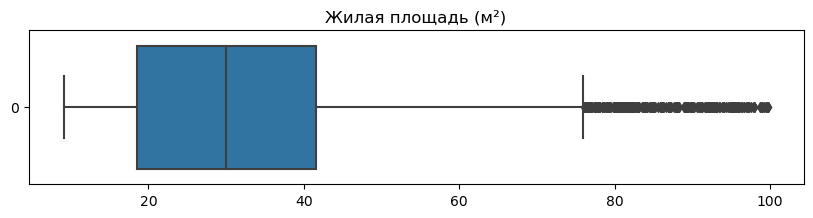

In [197]:
plt.figure(figsize=(10, 2))
ax = sns.boxplot(data=df['living_area'], orient="h")
ax.set(
    title = 'Жилая площадь (м²)'
)

In [198]:
df.shape

(22975, 23)

##### Цена

In [199]:
df.shape

(22975, 23)

In [200]:
df['last_price'].describe()

count    2.297500e+04
mean     5.879456e+06
std      6.076615e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.570000e+06
75%      6.500000e+06
max      2.892384e+08
Name: last_price, dtype: float64

<AxesSubplot:>

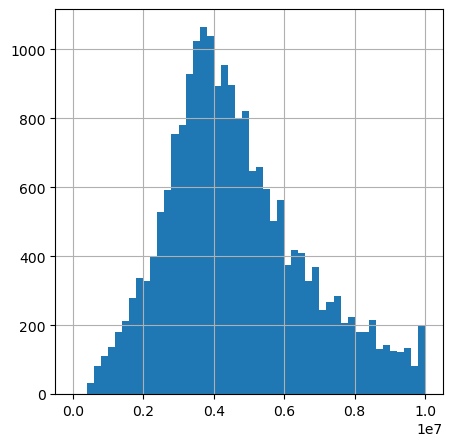

In [201]:
df['last_price'].hist(grid=True, range=(0, 10000000), bins=50, figsize=(5, 5))

Если присмотреться к минимальным значениям, то мы видим одну квартиру, которая стоит особняком - стоит убрать её из нашей выборки.

<AxesSubplot:>

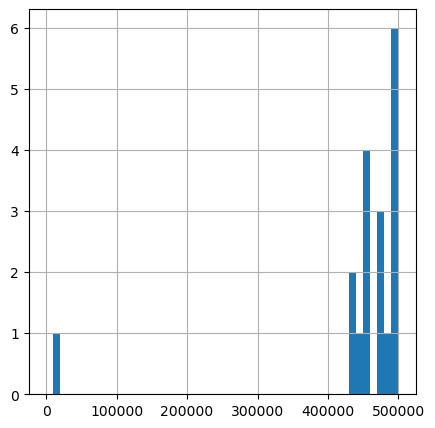

In [202]:
df['last_price'].hist(grid=True, range=(0, 500000), bins=50, figsize=(5, 5))

[Text(0.5, 1.0, 'Цена')]

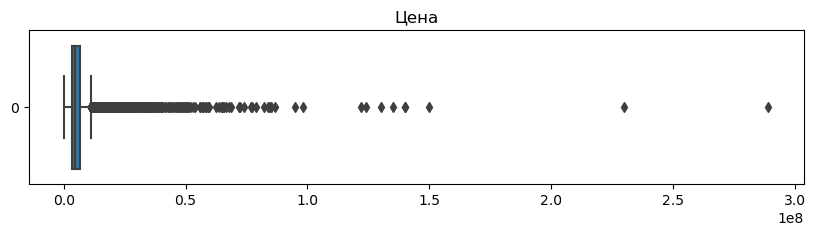

In [203]:
plt.figure(figsize=(10, 2))
ax = sns.boxplot(data=df['last_price'], orient="h")
ax.set(
    title = 'Цена'
)

In [204]:
df = df.query('(last_price < 30000000 and last_price > 100000) or last_price.isnull()', engine='python')

In [205]:
df.shape

(22807, 23)

##### Общая площадь

Теперь разберемся с параметром общей площади.

In [206]:
df['total_area'].describe()

count    22807.000000
mean        56.578753
std         24.148576
min         12.000000
25%         40.000000
50%         51.000000
75%         67.000000
max        441.980000
Name: total_area, dtype: float64

[Text(0.5, 1.0, 'Общая площадь (м²)')]

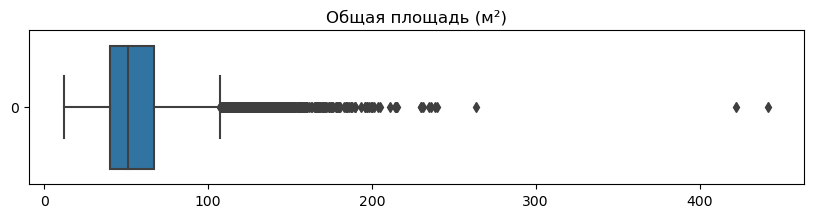

In [207]:
plt.figure(figsize=(10, 2))
ax = sns.boxplot(data=df['total_area'], orient="h")
ax.set(
    title = 'Общая площадь (м²)'
)

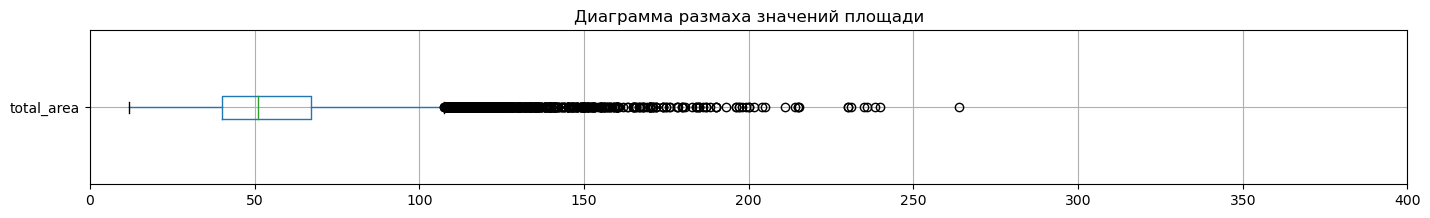

In [208]:
# check
# для примера горизонтальный вид диаграммы размаха

fig, ax = plt.subplots(figsize = (17,2))
ax = df[['total_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади')
ax.set_xlim(0, 400);

Text(0.5, 1.0, 'Общая площадь (м²)')

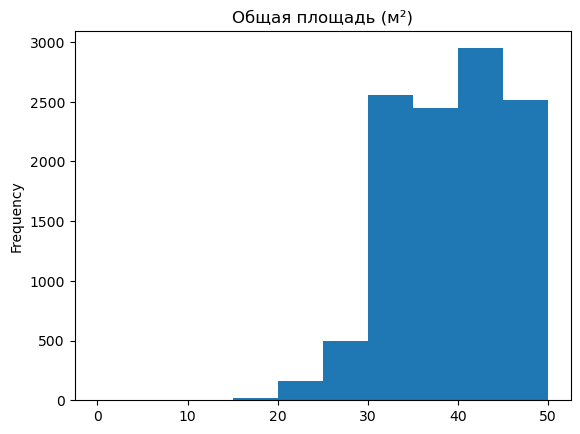

In [209]:
ax = df['total_area'].plot(kind='hist', range=(0, 50))
plt.title('Общая площадь (м²)')

Как видно из графиков, квартиры общей площадью до 25м и более 250м встречаются относительно редко.

In [210]:
df = df.query('total_area < 250 or total_area.isnull()', engine='python')

In [211]:
df = df.query('total_area > 25 or total_area.isnull()', engine='python')

In [212]:
df.shape

(22576, 23)

##### Количество этажей в доме

In [213]:
df['floors_total'].describe()

count    22496.000000
mean        10.790096
std          6.609620
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

<AxesSubplot:>

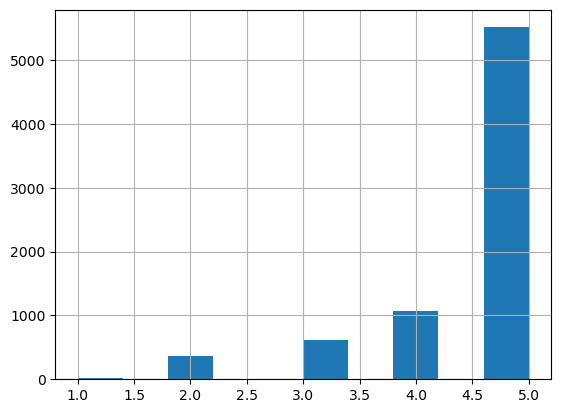

In [214]:
df['floors_total'].hist(range=(1, 5))

<AxesSubplot:>

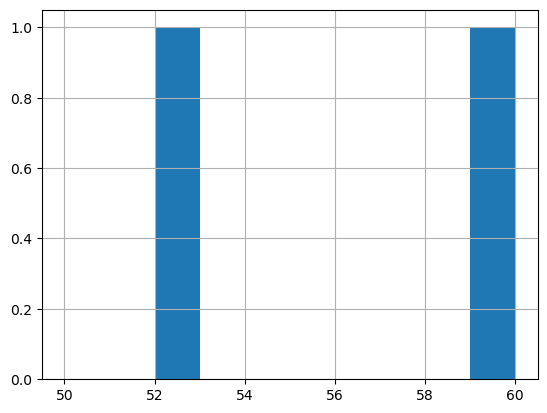

In [215]:
df['floors_total'].hist(range=(50, 60))

Как мы видим, количество этажей в доме также содержит в себе нестандартные значения. В таблице только 2 объекта в диапазоне от 50 до 60. Ограничим нашу выборку.

In [216]:
df = df.query('floors_total < 50 or floors_total.isnull()', engine='python')

In [217]:
df['floors_total'].describe()

count    22494.000000
mean        10.786076
std          6.596043
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         36.000000
Name: floors_total, dtype: float64

##### Количество комнат

In [218]:
df.rooms.value_counts().to_frame()

,rooms
1,7824
2,7823
3,5585
4,1021
5,172
0,117
6,24
7,7
9,1


In [219]:
df['rooms'].describe()

count    22574.000000
mean         2.009879
std          0.943981
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          9.000000
Name: rooms, dtype: float64

Здравый смысл подсказывает, что квартиры с 0 комнатами - это студии. Мы можем оставить только те объекты, в которых не более 6 комнат, т.к. остальных объектов относительно мало (8 из всего датасета). Исправим данные в таблице.

In [220]:
df = df.query('rooms < 7 or rooms.isnull()', engine='python')

In [221]:
df['rooms'].describe()

count    22566.000000
mean         2.008021
std          0.938894
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64

##### Площадь кухни

In [222]:
df['kitchen_area'].describe()

count    20544.000000
mean        10.169520
std          4.892765
min          1.300000
25%          7.000000
50%          9.000000
75%         11.600000
max         70.000000
Name: kitchen_area, dtype: float64

<AxesSubplot:>

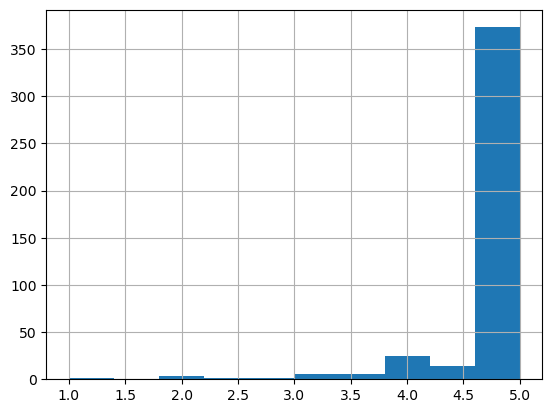

In [223]:
df['kitchen_area'].hist(range=(1, 5))

<AxesSubplot:>

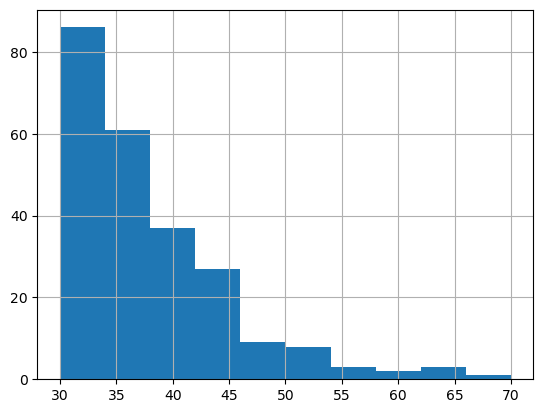

In [224]:
df['kitchen_area'].hist(range=(30, 70))

[Text(0.5, 1.0, 'Общая площадь кухни (м²)')]

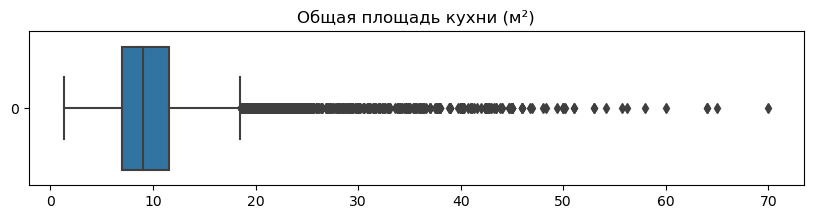

In [225]:
plt.figure(figsize=(10, 2))
ax = sns.boxplot(data=df['kitchen_area'], orient="h")
ax.set(
    title = 'Общая площадь кухни (м²)'
)

Как мы видим из двух гистограмм выше, количество объектов с кухней меньше 4м и больше 50м незначительно. 

In [226]:
df = df.query('kitchen_area >= 4 or kitchen_area.isnull()', engine='python')

In [227]:
df = df.query('kitchen_area <= 50 or kitchen_area.isnull()', engine='python')

In [228]:
df['kitchen_area'].describe()

count    20512.000000
mean        10.143532
std          4.730221
min          4.000000
25%          7.000000
50%          9.000000
75%         11.592500
max         50.000000
Name: kitchen_area, dtype: float64

In [229]:
df.shape

(22534, 23)

##### Количество дней в публикации

In [230]:
df['days_exposition'].describe()

count    19589.000000
mean       178.449487
std        217.107191
min          1.000000
25%         45.000000
50%         94.000000
75%        227.000000
max       1580.000000
Name: days_exposition, dtype: float64

<AxesSubplot:>

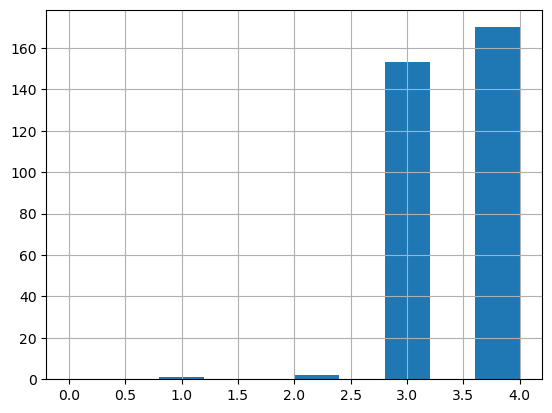

In [231]:
df['days_exposition'].hist(range=(0, 4))

<AxesSubplot:>

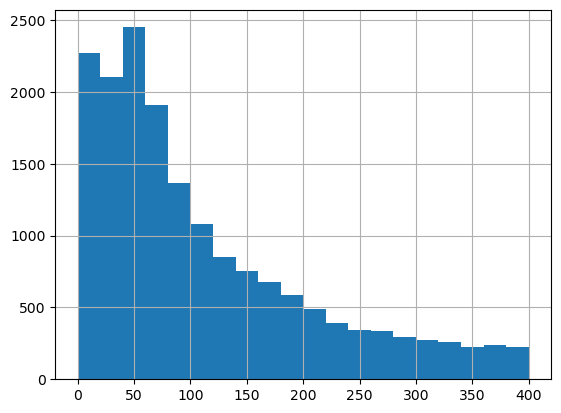

In [232]:
df['days_exposition'].hist(range=(0, 400), bins=20)

Как видно на наших гистограммах, объектов, снятых с публикации меньше чем через 3 дня, крайне мало. То же мы можем сказать и о количестве объектов, снятых с публикации после 1000-го дня.

In [233]:
df = df.query('days_exposition > 2 or days_exposition.isnull()', engine='python')

In [234]:
df = df.query('days_exposition <= 1000 or days_exposition.isnull()', engine='python')

In [235]:
df.shape

(22279, 23)

#### Промежуточные выводы

На данном этапе мы обработали пропущенные значения и устранили их для двух столбцов. Унифицировали названия столбцов. Изменили типы данных на необходимые.

Перероверим наличие аномальных значений в столбцах.

In [236]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

data = df.copy()
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,279.00","22,279.00","13,494.00","19,334.00","22,279.00","20,508.00","20,271.00","22,279.00","22,201.00"
min,0.00,25.07,2.25,3.00,"430,000.00",9.10,4.00,1.00,1.00
max,6.00,240.00,3.49,"1,000.00","29,999,000.00",99.80,50.00,33.00,36.00


In [237]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.01, .5, .90, .9976])  
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.010000,1.00,28.30,2.50,4.00,"1,000,000.00",13.50,5.00,1.00,2.00
0.500000,2.00,51.00,2.64,92.00,"4,550,000.00",30.00,9.00,4.00,9.00
0.900000,3.00,86.70,3.00,428.00,"9,600,000.00",51.60,15.00,13.00,22.00
0.997600,5.00,170.37,3.40,961.00,"26,557,532.80",93.58,40.00,25.00,27.00


### Посчитайте и добавьте в таблицу новые столбцы

In [238]:
#цена одного квадратного метра
df['square_metre_price'] = round(df['last_price'] / df['total_area'])

In [239]:
df['square_metre_price'] = df['square_metre_price'].astype('Int64', errors='ignore')

In [240]:
#день недели публикации объявления
df['day_of_publication'] = df['first_day_exposition'].dt.weekday

In [241]:
#месяц публикации объявления
df['month_of_publication'] = df['first_day_exposition'].dt.strftime("%m")

In [242]:
#год публикации объявления
df['year_of_publication'] = df['first_day_exposition'].dt.strftime("%Y")

In [243]:
#тип этажа квартиры (значения — «первый», «последний», «другой»)
def categorize_the_floor (row):
    if row['floor'] == 1:
        return 'Первый'
    elif row['floor'] == row['floors_total']:
        return 'Последний'
    elif row['floor'] == 0:
        return 'Цокольный этаж'
    elif row['floor'] < 0:
        return 'Подвал'
    else:
        return 'Другой'

In [244]:
sample = df.dropna(subset=['floors_total']).copy()

In [245]:
df['type_of_floor'] = sample.apply(categorize_the_floor, axis=1)

In [246]:
#расстояние до центра города в километрах
df['distance_to_city_center_in_km'] = round(df['nearest_city_center'] // 1000).astype('Int64', errors='ignore')

#### Промежуточные выводы

Мы добавили столбцы в таблицу. Они должны упростить ход дальнейшей работы. 

### Проведите исследовательский анализ данных

#### Гистограммы основных столбцов

Text(0, 0.5, 'Количество объектов')

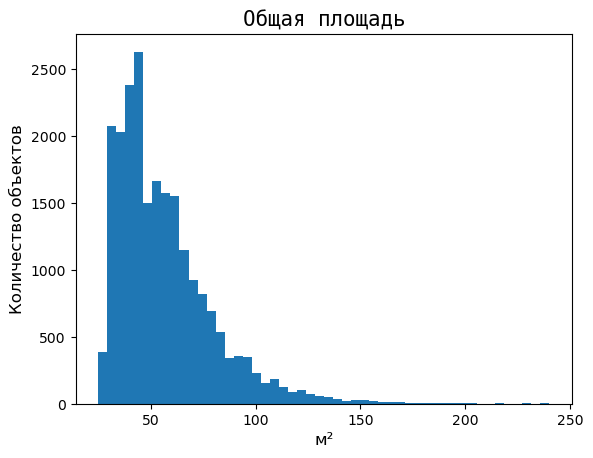

In [247]:
#общая площадь
ax = df['total_area'].plot(kind='hist', bins=50)
ax.set_title('Общая площадь',
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 15)
ax.set_xlabel('м²', fontsize = 12)
ax.set_ylabel('Количество объектов', fontsize = 12)

Text(0, 0.5, 'Количество объектов')

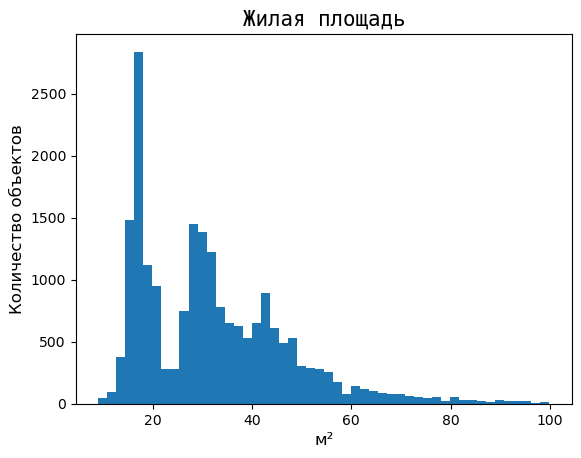

In [248]:
#жилая площадь
ax = df['living_area'].plot(kind='hist', bins=50)
ax.set_title('Жилая площадь',
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 15)
ax.set_xlabel('м²', fontsize = 12)
ax.set_ylabel('Количество объектов', fontsize = 12)

Text(0, 0.5, 'Количество объектов')

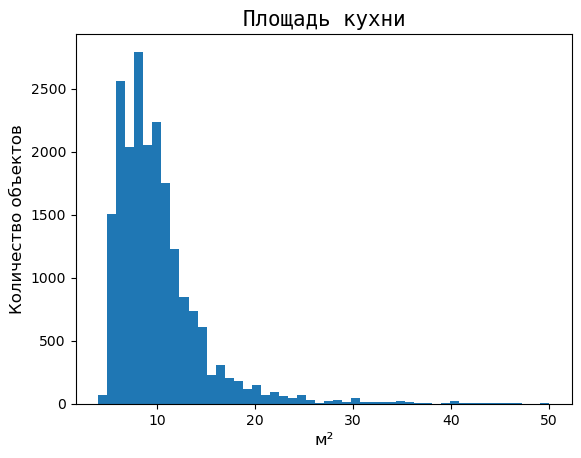

In [249]:
#площадь кухни
ax = df['kitchen_area'].plot(kind='hist', bins=50)
ax.set_title('Площадь кухни',
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 15)
ax.set_xlabel('м²', fontsize = 12)
ax.set_ylabel('Количество объектов', fontsize = 12)

Text(0, 0.5, 'Количество объектов')

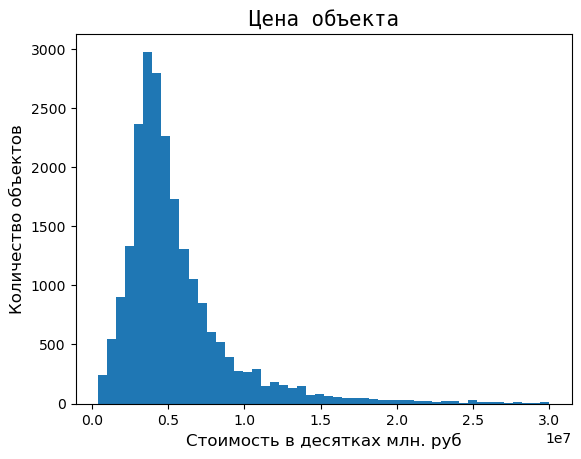

In [250]:
#цена объекта
ax = df['last_price'].plot(kind='hist', bins=50)
ax.set_title('Цена объекта',
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 15)
ax.set_xlabel('Стоимость в десятках млн. руб', fontsize = 12)
ax.set_ylabel('Количество объектов', fontsize = 12)

Text(0, 0.5, 'Количество объектов')

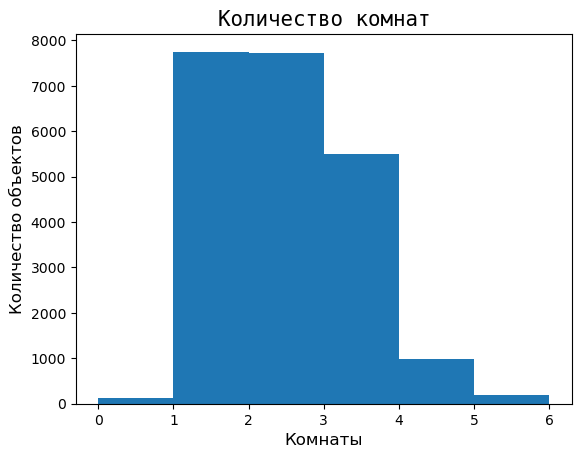

In [251]:
#количество комнат
ax = df['rooms'].plot(kind='hist', bins=6)
ax.set_title('Количество комнат',
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 15)
ax.set_xlabel('Комнаты', fontsize = 12)
ax.set_ylabel('Количество объектов', fontsize = 12)

Text(0, 0.5, 'Количество объектов')

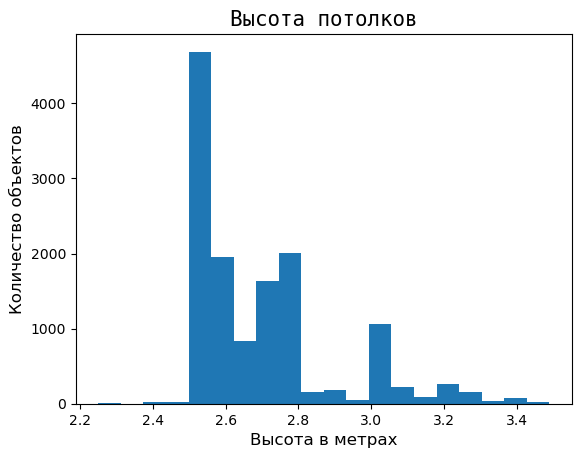

In [252]:
#высота потолков
ax = df['ceiling_height'].plot(kind='hist', bins=20)
ax.set_title('Высота потолков',
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 15)
ax.set_xlabel('Высота в метрах', fontsize = 12)
ax.set_ylabel('Количество объектов', fontsize = 12)

Text(0, 0.5, 'Количество объектов')

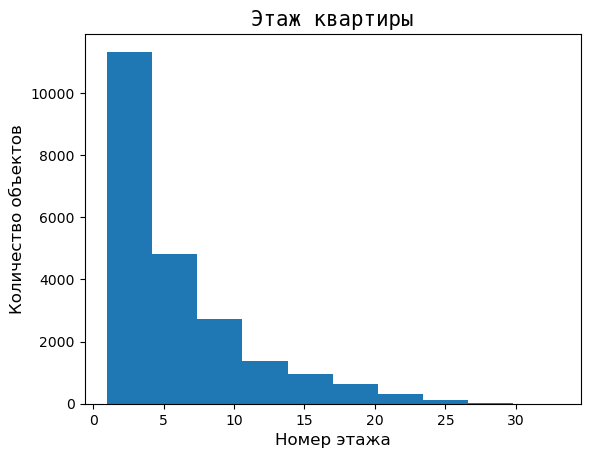

In [253]:
# этаж квартиры
ax = df['floor'].plot(kind='hist', bins=10)
ax.set_title('Этаж квартиры',
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 15)
ax.set_xlabel('Номер этажа', fontsize = 12)
ax.set_ylabel('Количество объектов', fontsize = 12)

Text(0, 0.5, 'Количество объектов')

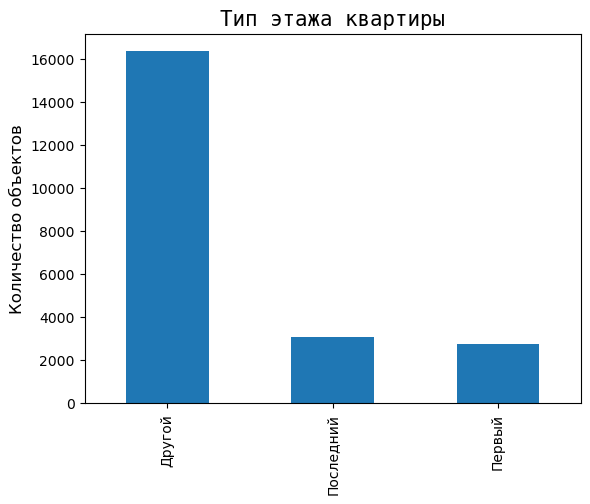

In [254]:
#тип этажа квартиры
ax = df['type_of_floor'].value_counts().sort_values(ascending=False).plot(kind='bar')
ax.set_title('Тип этажа квартиры',
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 15)
ax.set_ylabel('Количество объектов', fontsize = 12)

Первый и последний этажи одинаково популярны.

Text(0, 0.5, 'Количество объектов')

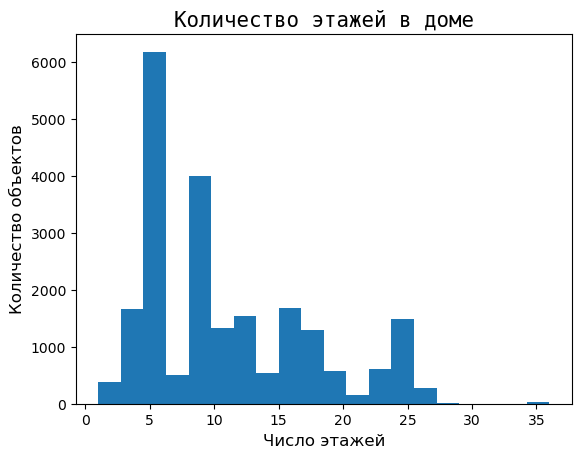

In [255]:
#общее количество этажей в доме
ax = df['floors_total'].plot(kind='hist', bins=20)
ax.set_title('Количество этажей в доме',
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 15)
ax.set_xlabel('Число этажей', fontsize = 12)
ax.set_ylabel('Количество объектов', fontsize = 12)

Количество пятиэтажных домов лидирует, затем идут девятиэтажки и прочие.

Text(0, 0.5, 'Количество объектов')

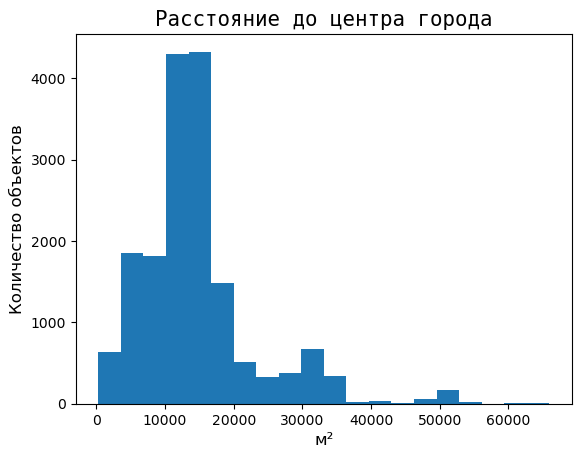

In [256]:
#расстояние до центра города в метрах
ax = df['nearest_city_center'].plot(kind='hist', bins=20)
ax.set_title('Расстояние до центра города',
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 15)
ax.set_xlabel('м²', fontsize = 12)
ax.set_ylabel('Количество объектов', fontsize = 12)

В столбце расстояния есть вполне ожидаемое падение количества квартир после отметки в 19км. Это границы города Санкт-Петербурга. Остальные значения похожи на выбросы.

Text(0, 0.5, 'Количество объектов')

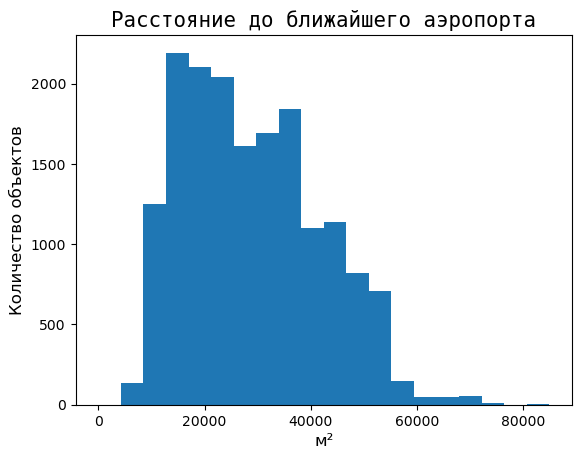

In [257]:
#расстояние до ближайшего аэропорта
ax = df['airports_nearest'].plot(kind='hist', bins=20)
ax.set_title('Расстояние до ближайшего аэропорта',
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 15)
ax.set_xlabel('м²', fontsize = 12)
ax.set_ylabel('Количество объектов', fontsize = 12)

Text(0, 0.5, 'Количество объектов')

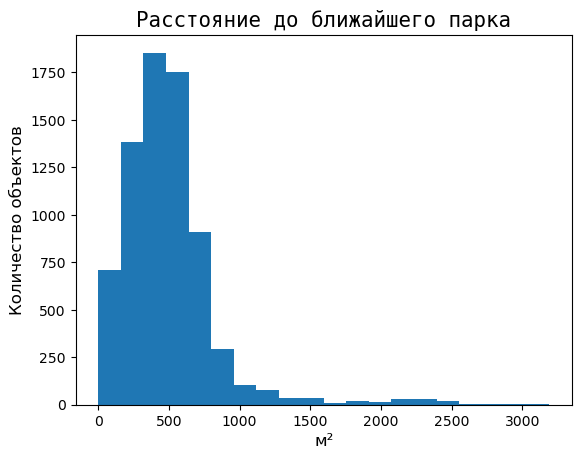

In [258]:
#расстояние до ближайшего парка
ax = df['parks_nearest'].plot(kind='hist', bins=20)
ax.set_title('Расстояние до ближайшего парка',
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 15)
ax.set_xlabel('м²', fontsize = 12)
ax.set_ylabel('Количество объектов', fontsize = 12)

Расстояние до ближайшего парка распределено равномерно, хотя ещё сохранились значения в районе 0, что вызывает подозрения.

In [259]:
df1['day_of_publication'] = df['day_of_publication'] + 1
df1['day_of_publication'] 

0        4
1        2
2        4
4        2
5        1
        ..
23693    5
23695    1
23696    7
23697    2
23698    5
Name: day_of_publication, Length: 22279, dtype: int64

Text(0, 0.5, 'Количество объектов')

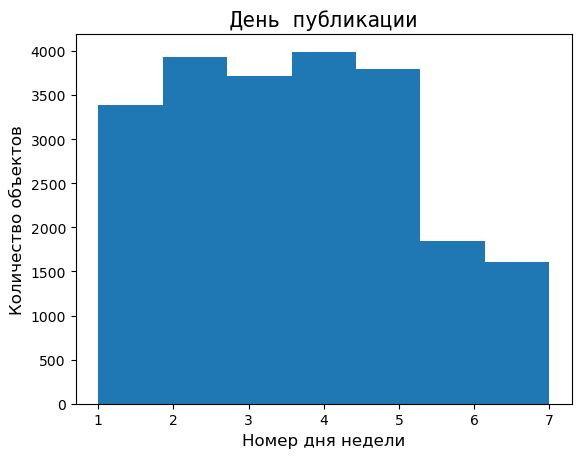

In [260]:
#день публикации объявления\
#переведем числа в стандартный формат (понедельник - первый день)
df1['day_of_publication'] = df['day_of_publication'] + 1
df1['day_of_publication'] 

#построим график
ax = df1['day_of_publication'].plot(kind='hist', bins=7)
ax.set_title('День публикации',
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 15)
ax.set_xlabel('Номер дня недели', fontsize = 12)
ax.set_ylabel('Количество объектов', fontsize = 12)

Наименее активные дни публикаций - выходные. Отрыв почти в два раза.

Text(0, 0.5, 'Количество объектов')

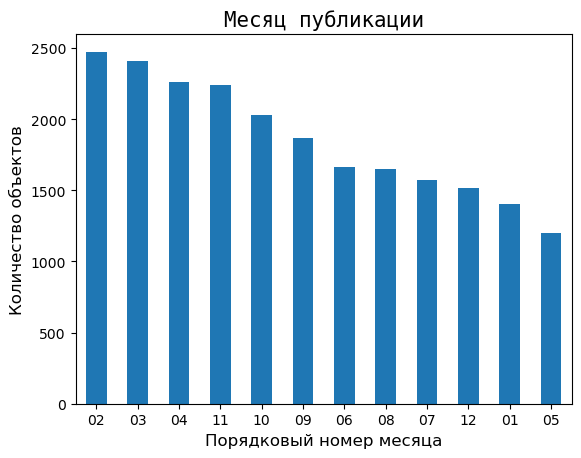

In [261]:
#месяц публикации объявления
ax = df['month_of_publication'].value_counts().plot(kind='bar')
ax.set_title('Месяц публикации',
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 15)
plt.xticks(rotation=0)
ax.set_xlabel('Порядковый номер месяца', fontsize = 12)
ax.set_ylabel('Количество объектов', fontsize = 12)

Самыми популярными месяцами для публикации выступают месяцы с февраля по апрель, а также октябрь и ноябрь. Наименее популярные месяцы - июнь и январь.

#### Анализируем столбец days_exposition

Теперь перейдем к столбцу days_exposition, который показывает скорость снятия публикаций.

In [262]:
df['days_exposition'].describe()

count    19334.000000
mean       165.590566
std        186.059915
min          3.000000
25%         44.000000
50%         92.000000
75%        218.000000
max       1000.000000
Name: days_exposition, dtype: float64

Text(0, 0.5, 'Количество объектов')

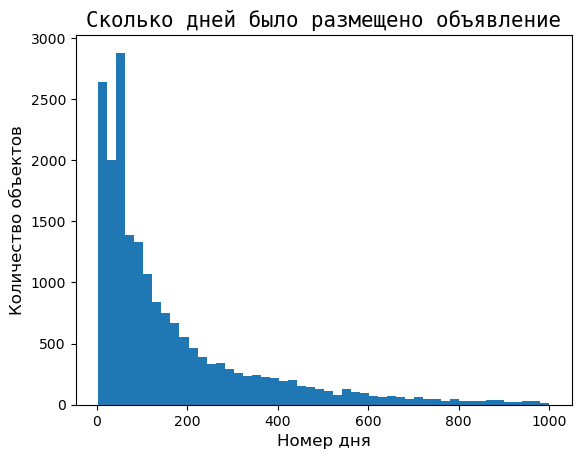

In [263]:
ax = df['days_exposition'].plot(kind='hist', bins=50)
ax.set_title('Сколько дней было размещено объявление',
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 15)
ax.set_xlabel('Номер дня', fontsize = 12)
ax.set_ylabel('Количество объектов', fontsize = 12)

Как мы видим на гистограмме, в таблице есть значения, которые встречаются наиболее часто. Определим их и попытаемся объяснить.

In [264]:
df['days_exposition'].value_counts()

45     855
60     528
7      226
30     200
90     176
      ... 
634      1
673      1
842      1
923      1
971      1
Name: days_exposition, Length: 931, dtype: Int64

Таковыми являются значения в 45, 60, 7, 30 и 90 дней. Мы можем предположить, что это рубежные значения для различных типов объявлений. К примеру, правила размещения объявления на сайте недвижимости разграничивают сроки публикации для разных объектов на основании их стоимости. Для Яндекс.Недвижимости сроки следующие:

до 4,5 млн — 45 дней, от 4,5 до 10 млн — 60 дней, от 10 млн — 90 дней

На следующих гистограммах мы посмотрим на связь между сроком снятия с публикации и стоимостью объекта. Мы ожидаем увидеть картину, которая будет вписываться в условия, представленнные на сайте.

In [266]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,locality_name_new,square_metre_price,day_of_publication,month_of_publication,year_of_publication,type_of_floor,distance_to_city_center_in_km
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,True,...,2,755,<NA>,Санкт-Петербург,120370,3,03,2019,Другой,16
1,7,3350000,40.4,2018-12-04,1,NaN,11,18.6,1,True,...,0,<NA>,81,Шушары,82921,1,12,2018,Первый,18
2,10,5196000,56.0,2015-08-20,2,NaN,5,34.3,4,True,...,2,574,558,Санкт-Петербург,92786,3,08,2015,Другой,13
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,True,...,1,48,121,Санкт-Петербург,100000,1,06,2018,Другой,8
5,10,2890000,30.4,2018-09-10,1,NaN,12,14.4,5,True,...,<NA>,<NA>,55,Янино-1,95066,0,09,2018,Другой,<NA>


Text(0, 0.5, 'Количество объектов')

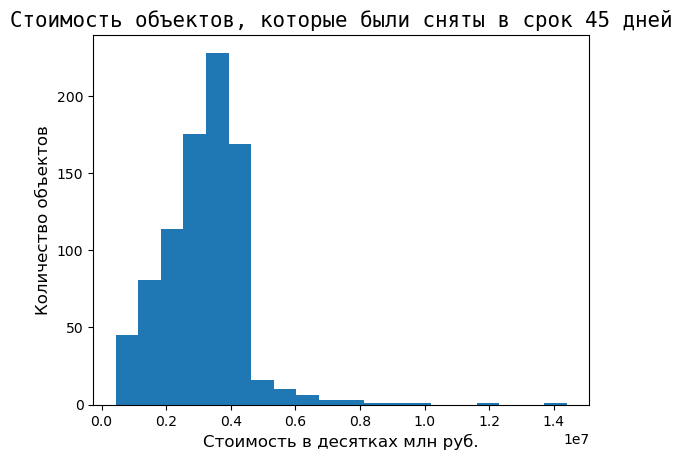

In [286]:
s = df.loc[df.loc[:, 'days_exposition']==45]
ax = s['last_price'].plot(kind='hist', bins=20)
ax.set_title('Стоимость объектов, которые были сняты в срок 45 дней',
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 15)
ax.set_xlabel('Стоимость в десятках млн руб.', fontsize = 12)
ax.set_ylabel('Количество объектов', fontsize = 12)

Text(0, 0.5, 'Количество объектов')

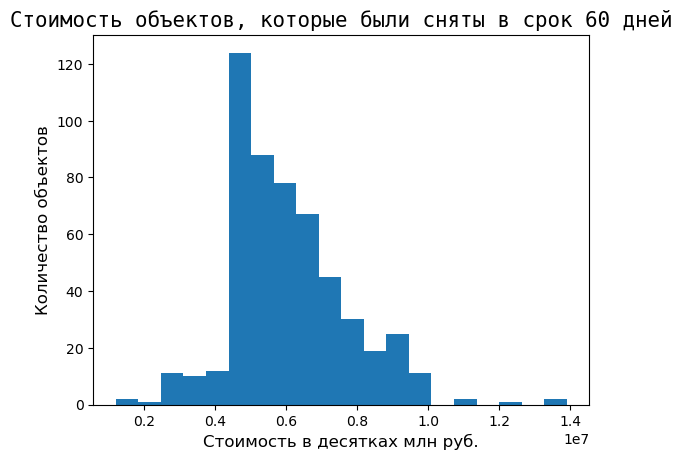

In [288]:
q = df.loc[df.loc[:, 'days_exposition']==60]
ax = q['last_price'].plot(kind='hist', bins=20)
ax.set_title('Стоимость объектов, которые были сняты в срок 60 дней',
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 15)
ax.set_xlabel('Стоимость в десятках млн руб.', fontsize = 12)
ax.set_ylabel('Количество объектов', fontsize = 12)

Text(0, 0.5, 'Количество объектов')

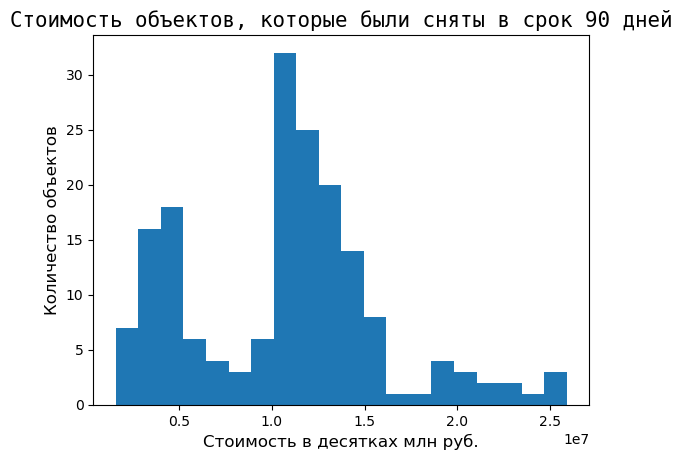

In [289]:
r = df.loc[df.loc[:, 'days_exposition']==90]
ax = r['last_price'].plot(kind='hist', bins=20)
ax.set_title('Стоимость объектов, которые были сняты в срок 90 дней',
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 15)
ax.set_xlabel('Стоимость в десятках млн руб.', fontsize = 12)
ax.set_ylabel('Количество объектов', fontsize = 12)

Как мы и предполагали, стоимость объектов в среднем укладывается в рамки, которые заданы платформой. Есть свои исключения, но пик стоимости всегда приходится на значения соответствующего типа объявлений.

Единственным странным значением здесь выступает срок в 7 дней, который на тех же сайтах ограничивает сроки публикации объявления о комнате, а не о квартире. Проверим на гистограмме.

Text(0, 0.5, 'Количество объектов')

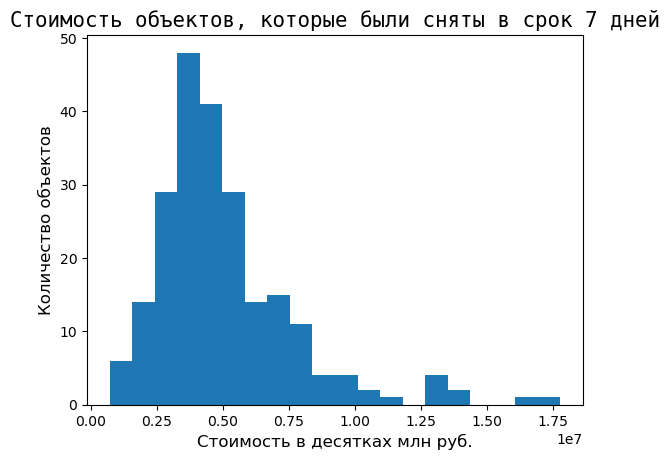

In [292]:
t = df.loc[df.loc[:, 'days_exposition']==7]
ax = t['last_price'].plot(kind='hist', bins=20)
ax.set_title('Стоимость объектов, которые были сняты в срок 7 дней',
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 15)
ax.set_xlabel('Стоимость в десятках млн руб.', fontsize = 12)
ax.set_ylabel('Количество объектов', fontsize = 12)

Наша догадка оказалась неверной. Квартиры стоимостью около 3-4млн руб. редко, но всё же продаются за столь короткий срок.

Таким образом, мы можем сделать следующие выводы: 
* средняя скорость продажи в нашем случае - 90 дней,
* быстрые продажи - те, которые происходят в срок 7 дней,
* медленные - в срок более 400 дней.

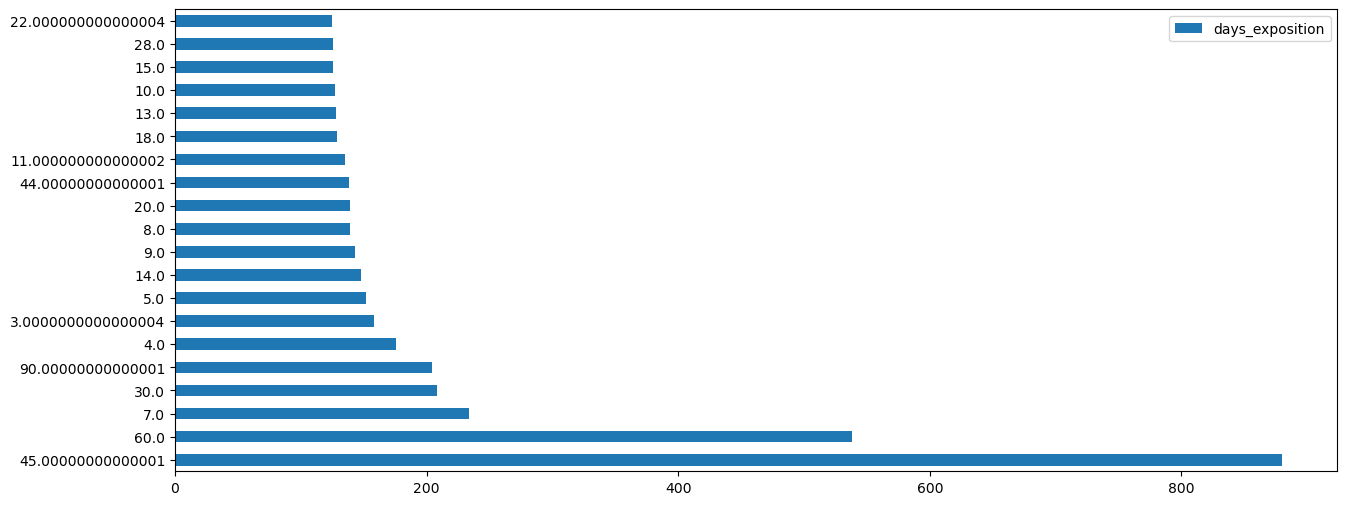

In [293]:
# check
# Моды на реальных данных

try:
    df_check = pd.read_csv('real_estate_data.csv', sep='\t') 
except:
    df_check = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
    
df_check['days_exposition'].value_counts().to_frame().head(20).plot(kind = 'barh', figsize = (15,6), rot = 0);

#### Анализируем факторы, которые влияют на стоимость объекта

##### Общая площадь

0.7734377392921706

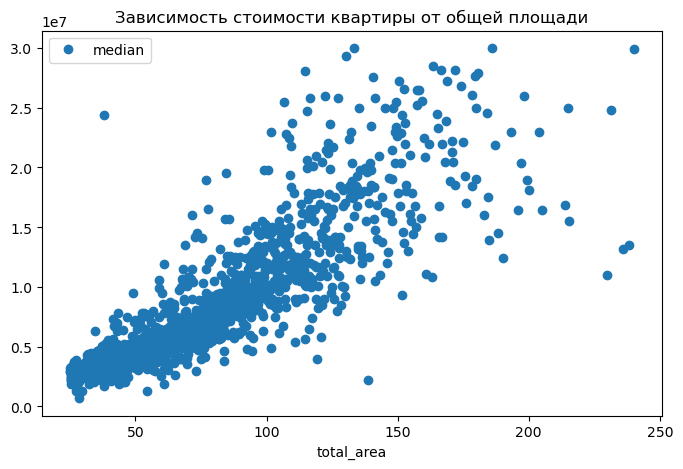

In [294]:
pivot_table_total_area = df.pivot_table(index = 'total_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y= 'median', style = 'o', title='Зависимость стоимости квартиры от общей площади', figsize=(8, 5))

pivot_table_total_area.sort_values('median', ascending = False)

df['total_area'].corr(df['last_price'])

Есть положительная зависимость. Чем больше квартира, тем она дороже.

##### Жилая площадь

0.6408866206935923

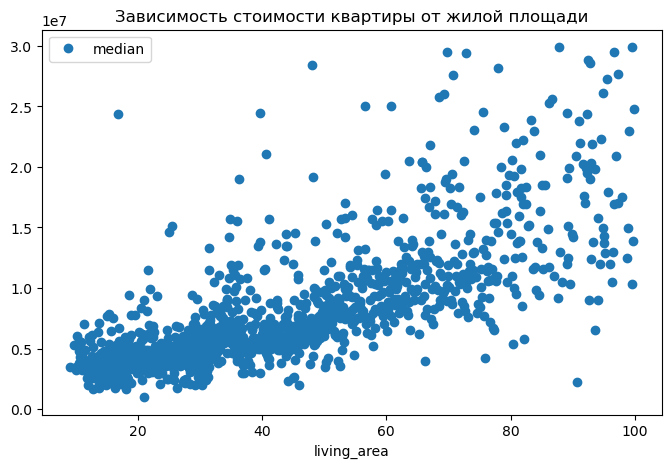

In [295]:
pivot_table_living_area = df.pivot_table(index = 'living_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_living_area.columns = ['mean', 'count', 'median']
pivot_table_living_area.plot(y= 'median', style = 'o', title='Зависимость стоимости квартиры от жилой площади', figsize=(8, 5))

pivot_table_living_area.sort_values('median', ascending = False)

df['living_area'].corr(df['last_price'])

С жилой площадью похожая история, хотя зависимость уже менее сильная.

##### Площадь кухни

0.5969822100839858

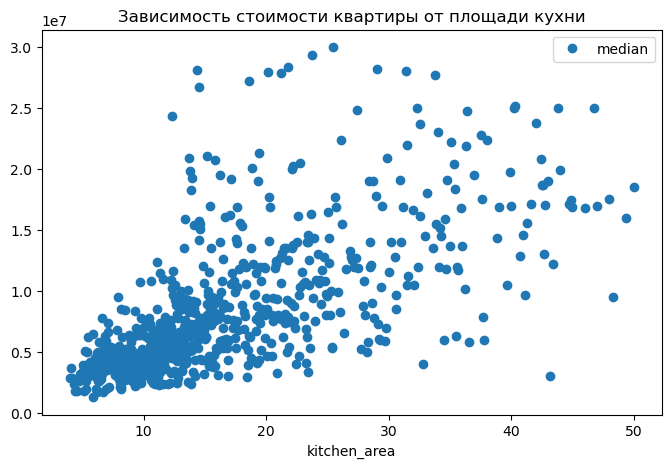

In [296]:
pivot_table_kitchen_area = df.pivot_table(index = 'kitchen_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_kitchen_area.columns = ['mean', 'count', 'median']
pivot_table_kitchen_area.plot(y= 'median', style = 'o', title='Зависимость стоимости квартиры от площади кухни', figsize=(8, 5))

pivot_table_kitchen_area.sort_values('median', ascending = False)

df['kitchen_area'].corr(df['last_price'])

Площадь кухни влияет на цену приблизительно так же, как и жилая площадь.

##### Количество комнат

0.4629808889983874

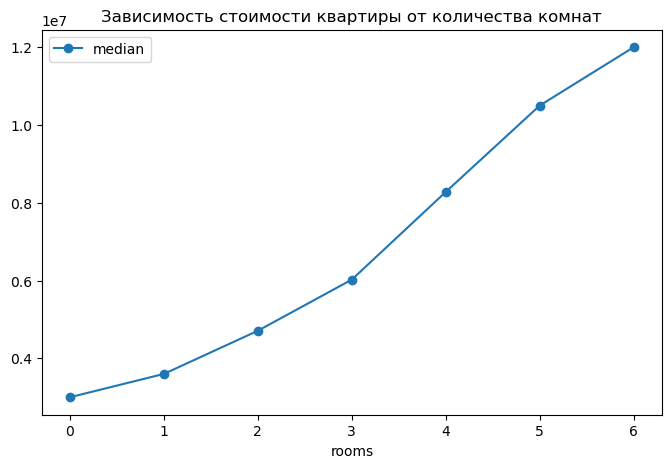

In [297]:
pivot_table_rooms = df.pivot_table(index = 'rooms', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_rooms.columns = ['mean', 'count', 'median']
pivot_table_rooms.plot(y= 'median', style = '-o', title='Зависимость стоимости квартиры от количества комнат', figsize=(8, 5))

pivot_table_rooms.sort_values('median', ascending = False)

df['rooms'].corr(df['last_price'])

Здесь мы наблюдаем позитивную зависимость цены от количества комнат.

##### Тип этажа

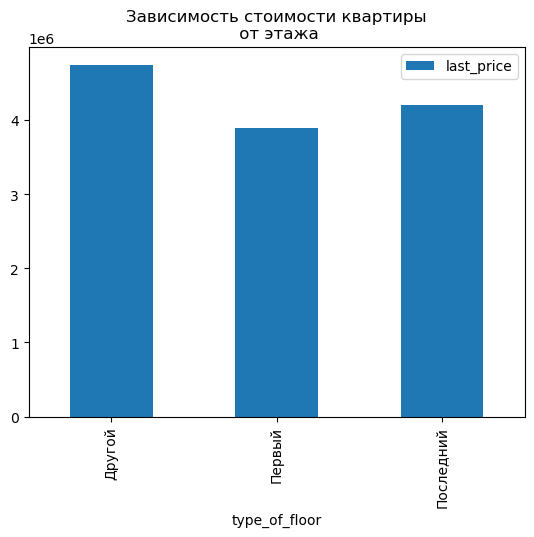

In [311]:
type_of_floor_median = df.groupby(['type_of_floor']).median()
type_of_floor_median.sort_values('type_of_floor').plot(y='last_price', \
                                                       kind='bar', title='Зависимость стоимости квартиры\n от этажа');

Цена объекта на первом этаже в среднем ниже, чем на любом другом.

##### День недели размещения

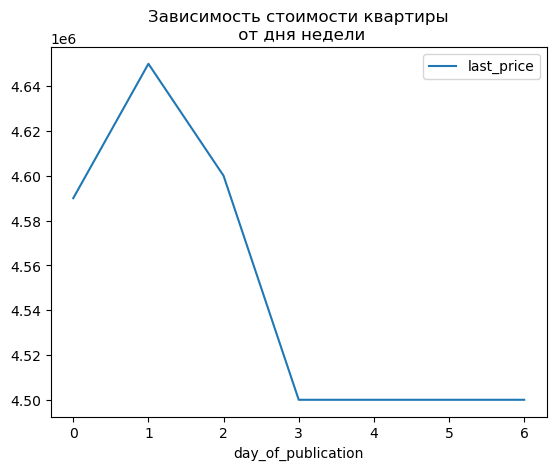

In [312]:
day_of_publication = df.groupby(['day_of_publication']).median()
day_of_publication.sort_values('day_of_publication').plot(y='last_price', \
                                                          title='Зависимость стоимости квартиры\n от дня недели');

Выходные дни заметно снижают стоимость объявления. Пик приходится на вторник. Трудно сказать, с чем это может быть связано.

##### Месяц размещения

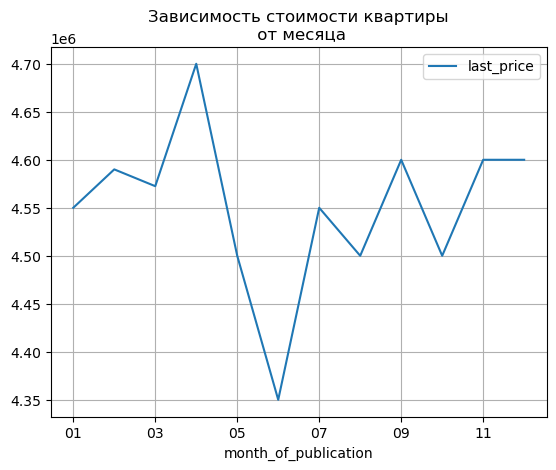

In [313]:
month_of_publication = df.groupby(['month_of_publication']).median()
month_of_publication.sort_values('month_of_publication').plot(y='last_price', grid=True, \
                                                              title='Зависимость стоимости квартиры\n от месяца');

Дешевле всего квартиры продаются в начале лета, а дороже всего - в апреле.

##### Год размещения

<AxesSubplot:title={'center':'Зависимость стоимости квартиры\n от года публикации/'}, xlabel='year_of_publication'>

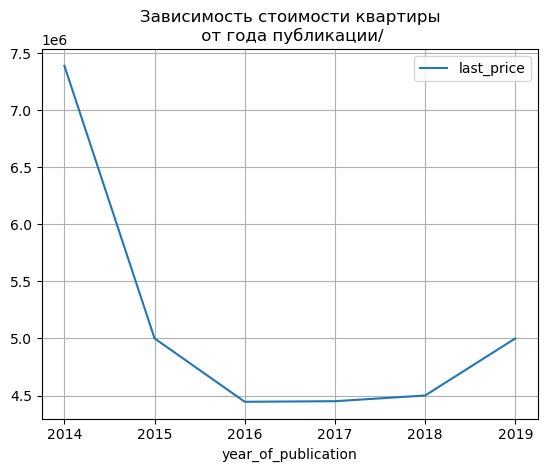

In [317]:
year_of_publication = df.groupby(['year_of_publication']).median()
year_of_publication = year_of_publication.query('~year_of_publication.isin([2014])')
year_of_publication.sort_values('year_of_publication').plot(y='last_price', \
                                                            grid=True, \
                                                            title='Зависимость стоимости квартиры\n от года публикации/')

Год размещения влияет на стоимость. С 2014 по 2017 цены падали, а затем снова стали повышаться.

In [318]:
# check
df.groupby(['year_of_publication']).median()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,airports_nearest,nearest_city_center,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,square_metre_price,day_of_publication,distance_to_city_center_in_km
year_of_publication,,,,,,,,,,,,,,,,,,,,,
2014,7.0,7388280.0,75.00,3.0,2.80,8.0,42.425,4.0,1.0,0.0,...,35233.5,11096.0,0.5,503.0,1.0,522.0,649.5,106266.0,2.0,11.0
2015,7.0,5000000.0,57.00,2.0,2.70,9.0,32.650,4.0,1.0,0.0,...,26195.5,12024.5,0.0,456.0,1.0,454.0,498.0,91195.0,2.0,12.0
2016,8.0,4445000.0,52.05,2.0,2.65,9.0,30.300,4.0,1.0,0.0,...,26116.5,13168.0,0.0,461.0,0.0,495.5,228.0,90954.5,2.0,13.0
2017,9.0,4450000.0,51.00,2.0,2.65,9.0,30.000,5.0,1.0,0.0,...,26757.0,13395.0,0.0,454.0,0.0,520.0,102.0,91667.0,3.0,13.0
2018,10.0,4500000.0,50.10,2.0,2.60,9.0,29.700,4.0,1.0,0.0,...,27933.0,13492.0,0.0,458.0,0.0,512.0,63.0,95079.0,3.0,13.0
2019,11.0,5000000.0,51.00,2.0,2.60,9.0,30.000,4.0,1.0,0.0,...,27388.0,13330.0,0.0,450.5,0.0,522.0,24.0,102571.0,2.0,13.0


#### Считаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [322]:
df['square_metre_price'] = df['square_metre_price'].astype('int', errors='ignore')

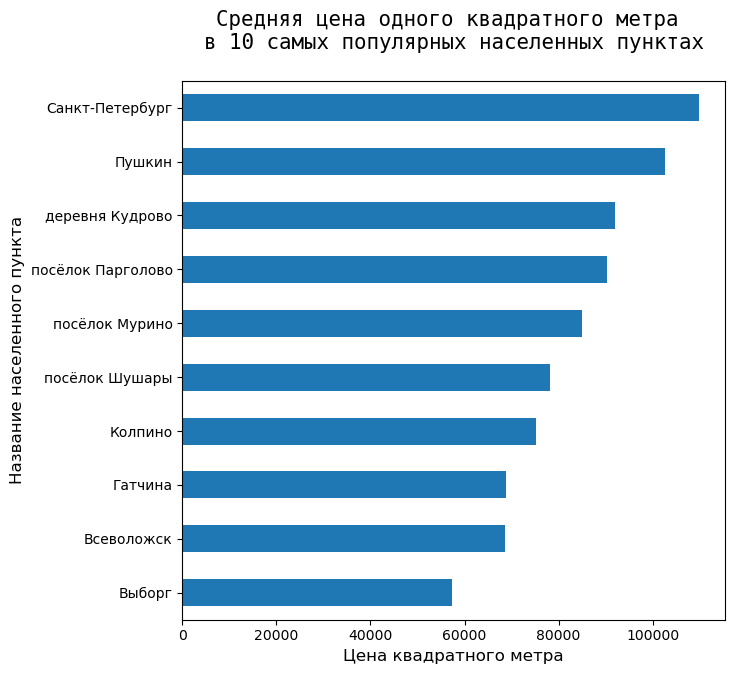

In [328]:
#Топ-10 населенных пунктов с наибольшим числом объявлений
ten_popular_locations = df['locality_name'].value_counts().sort_values(ascending = False)
ten_popular_locations=ten_popular_locations[0:10]

#Средняя цена за 1 квадратный метр
price_per_metre=df.pivot_table(index='locality_name', values='square_metre_price', aggfunc=('mean'))

#Перевод из Series в Dataset
ten_popular_locations = ten_popular_locations.reset_index()
ten_popular_locations.rename(columns = {'index':'locality_name', 'locality_name':'count'}, inplace = True)

#объединение двух таблиц
ten_popular_locations=ten_popular_locations.merge(price_per_metre, on='locality_name', how='left')
x = ['Выборг', 'Всеволожск', 'Гатчина', 'Колпино', 'посёлок Шушары', 'посёлок Мурино', 'посёлок Парголово', 'деревня Кудрово', 'Пушкин', 'Санкт-Петербург']

#построение графика
ax = (ten_popular_locations['square_metre_price']
      .sort_values(ascending = True)
      .plot(kind='barh', figsize=(7, 7)))

ax.set_title('Средняя цена одного квадратного метра \nв 10 самых популярных населенных пунктах' + "\n",
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 15)
ax.set_yticklabels(x)
ax.set_xlabel('Цена квадратного метра', fontsize = 12)
ax.set_ylabel('Название населенного пункта', fontsize = 12);

#### Считаем, как стоимость объектов зависит от расстояния до центра города

Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города

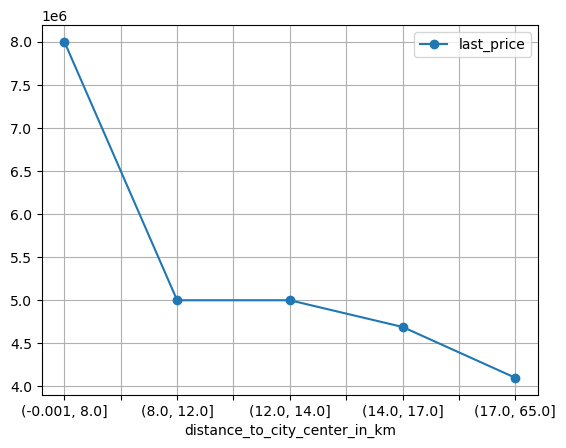

In [330]:
km_price = df[df['locality_name'] == 'Санкт-Петербург']

spb_distance_categories = pd.qcut(df['distance_to_city_center_in_km'], 5)
km_price_pivot = pd.pivot_table(df, index=spb_distance_categories, values=['last_price'], aggfunc='median')

km_price_pivot.plot(style='o-', grid=True);

На графике мы видим, что есть негативная зависимость цены от расстояния до центра. Чем дальше, тем дешевле. Наиболее остро эта зависимость выражена на расстоянии до 8км. С 8км до 14км цена не меняется, затем продолжает снижаться.

#### Промежуточные выводы

На данном этапе мы обратились к графикам:
* Построили гистограммы для каждого столбца и добавили комментарии там, где были обнаружены интересные особенности. 
* Мы также посчитали среднюю цену одного квадратного метра в 10 населённых пунктах: Санкт-Петербург ожидаемо оказался на первом месте, а Зеленогорск замкнул собой первую десятку.
* Обнаружили зависимость между расстоянием до центра города и стоимостью объектов

### Общий вывод

Итак, перед нами стояла задача найти интересные закономерности, которые существуют на рынке недвижимости.

Мы получили **портрет типового жилья**: площадь квартиры около 50м, где на жилую часть приходится 32м, а на кухню - 10м. В ней 1-2 комнаты. Потолки 2.7м. Удаленность от парка около 500м, от центра города - 13км, от аэропорта  - 25км. Стоит такая квартира около 4 млн руб.

Мы также выяснили, что:

* город обладает большим фондом малоэтажных зданий (в среднем до 10 этажей)
* объектов на первых пяти этажах больше, чем на других
* наименее активные дни публикаций - выходные
* самые популярные месяцы для публикации объявления - с февраля по апрель
* основная масса квартир находится на расстоянии до 19км от центра города
* среднее время продажи квартиры - 90 дней
* рекордная скорость продажи - 7 дней

Касательно **стоимости объектов**. На неё влияют:

1. площадь (общая, жилая, кухня)
2. количество комнат
3. год размещения (с 2017г. идет рост стоимости)

Причем:

* Санкт-Петербург имеет самую высокую стоимость квадратного метра, а Выборг - самую низкую
* Чем дальше от центра города, тем квадратный метр дешевле

### Дополнение

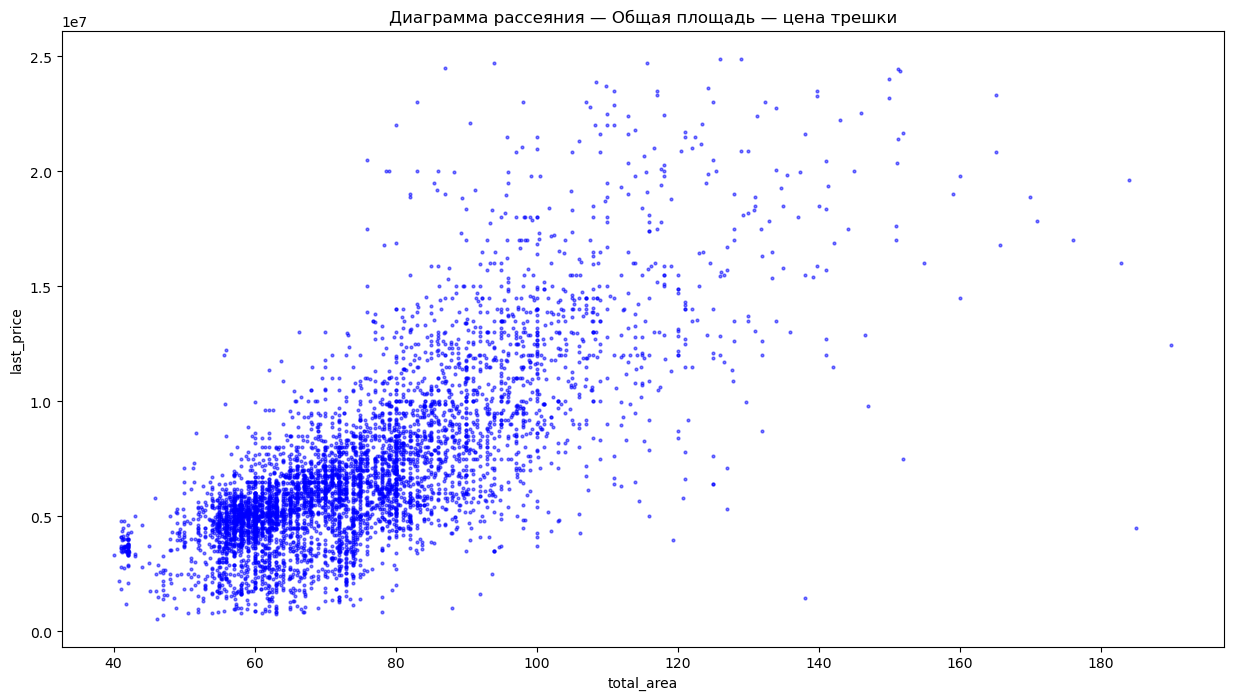

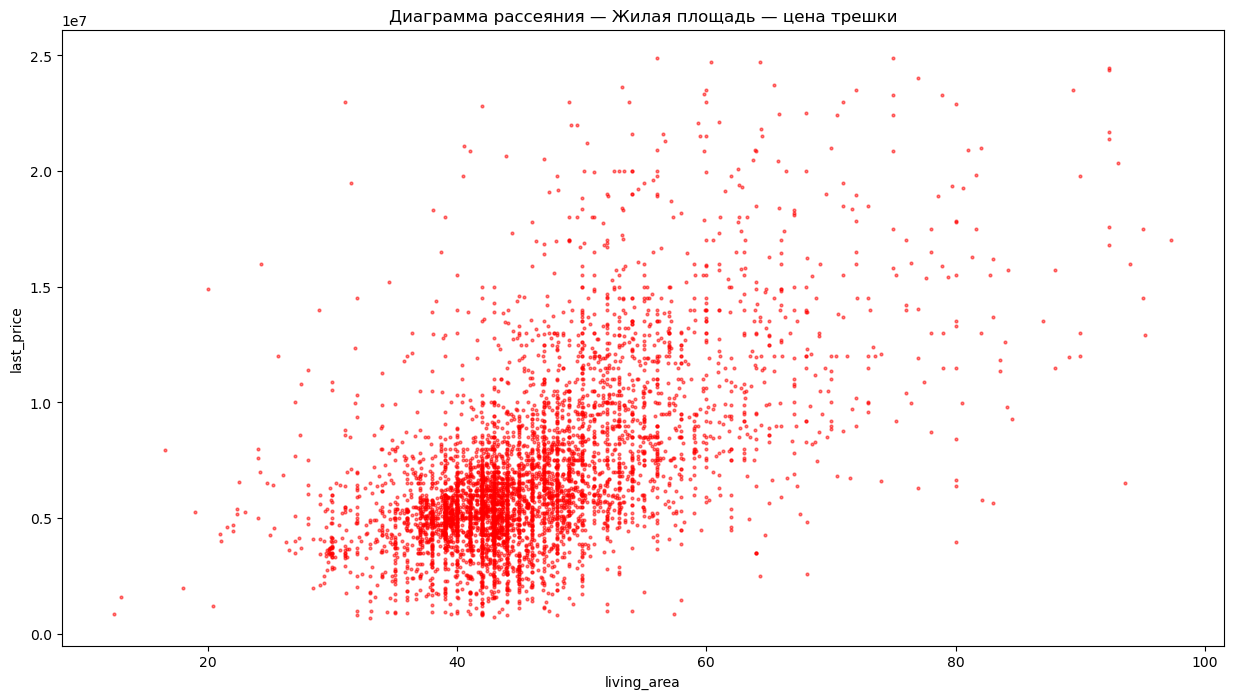

In [336]:
# диаграммы для трехкомнатной квартиры
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='last_price' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — цена трешки')


data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter', 
        y='last_price' , x='living_area', alpha=0.5, figsize=(15,8), c = 'r', s = 4)
plt.title('Диаграмма рассеяния — Жилая площадь — цена трешки');